# [2주차 과제] 지도학습 모델의 회귀 및 분류 성능 비교

## 과제 목표
- 선형 모델의 한계를 확인하고, 비선형 모델(SVR, Decision Tree, Ensemble)의 성능을 비교합니다.
- 지표 해석, 규제(Regularization), Bias-Variance에 대해 학습합니다.

## 데이터셋
- 회귀: California Housing
- 분류: Wine


## 제출 지침
- 원활한 의존성 라이브러리 사용을 위해 코랩 환경에서 진행하시는 것을 권장합니다.
- 각 문항 아래 코드 셀을 실행하고, `TODO` 주석이 있는 곳을 작성하세요.
    - '___' 부분에 알맞은 코드를 작성하시면 됩니다.
- 문항별 해석(서술형) 문항은 마크다운 셀('답안'으로 명시된 부분)에 작성하세요.


In [1]:
# 공통 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report

# 스타일 및 난수 시드값 고정
sns.set_theme(style='whitegrid')
RANDOM_STATE = 42

In [2]:
# 데이터 로드

# 회귀 문제용 데이터
housing = fetch_california_housing(as_frame=True)
X_reg = housing.data.copy()
y_reg = housing.target.copy()

# 분류 문제용 데이터
wine = load_wine(as_frame=True)
X_clf = wine.data.copy()
y_clf = wine.target.copy()

print('회귀 데이터:', X_reg.shape, y_reg.shape)
print('분류 데이터:', X_clf.shape, y_clf.shape)

회귀 데이터: (20640, 8) (20640,)
분류 데이터: (178, 13) (178,)


## [Section 1] EDA & Preprocessing

### 문제 1
1. 상관관계 Heatmap을 시각화하세요.
2. 타겟과 절대 상관계수가 가장 높은 특성 2개를 확인해보세요.


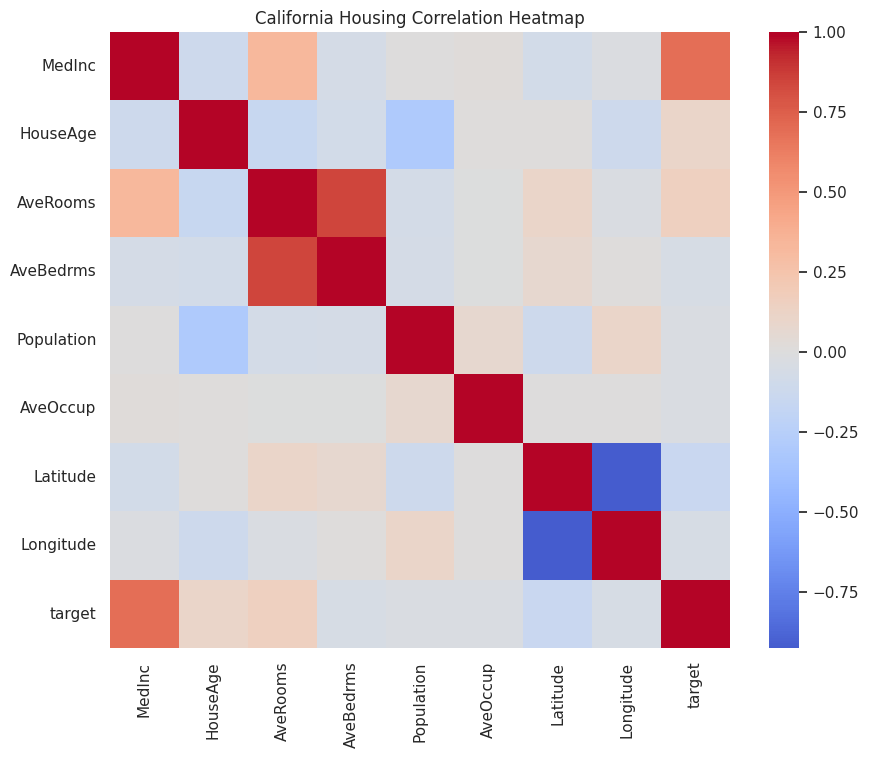

타겟과 상관계수 상위 2개 특성:
MedInc      0.688075
AveRooms    0.151948
Name: target, dtype: float64


In [3]:
# 문제 1: 회귀 데이터 상관관계 분석
reg_df = X_reg.copy()
reg_df['target'] = y_reg

# TODO 1) 상관계수 행렬 계산 메서드
corr = reg_df.corr(numeric_only=True)

# TODO 2) Heatmap 입력 데이터
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('California Housing Correlation Heatmap')
plt.show()

# TODO 3) target과 절대 상관계수 상위 2개 특성 추출
top2 = corr['target'].drop('target').abs().sort_values(ascending=False).head(2)
print('타겟과 상관계수 상위 2개 특성:')
print(top2)


### 문제 1 해석 작성
- (작성) 선택한 2개 특성이 타겟과 연관성이 높은 이유를 데이터셋을 고려하여 추론해보세요.

**답안:**

상관관계 분석 결과, MedInc와 AveRooms가 타켓과 높은 연관성을 보인다. MedInc은 지역의 소득 수준을 나타내며 소득 수준, 즉 경제적 수준은 주택 구매력과 직접적인 연관이 있으므로 높은 양의 상관관계를 보이고, AveRooms는 주택의 규모를 반영하는 변수로, 방 개수가 많을수록 가격이 높아지는 경향이 있기 때문에 높은 상관관계를 보이는 것으로 생각된다.



### 문제 2
1. `StandardScaler`로 표준화를 적용하세요.
2. 선형 모델/SVM에서 표준화가 중요한 이유를 서술하세요.


In [5]:
# 문제 2: 회귀 데이터 분할 + 표준화
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

scaler_reg = StandardScaler()
# TODO 4) 학습 데이터에 적용할 메서드
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
# TODO 5) 테스트 데이터에 적용할 메서드
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print('표준화 완료:', X_train_reg_scaled.shape, X_test_reg_scaled.shape)


표준화 완료: (16512, 8) (4128, 8)


### 문제 2 해석 작성
- (작성) 선형 모델에서 스케일 차이가 학습 안정성에 미치는 영향
- (작성) SVM/SVR에서 거리 기반 계산과 커널 값에 스케일이 주는 영향

**답안:**

선형 모델에서는 스케일이 큰 특성이 학습에 더 큰 영향을 주기에 모델이 불안정해질 수 있다. 또한 SVM/SVR은 거리 기반 모델이므로 스케일 차이가 거리 계산에 영향을 주어 성능 저하를 유발할 수 있다. 이때, 표준화를 통해 특성 간 균형을 맞추면 학습 안정성과 예측 성능이 향상될 수 있다.



## [Section 2] Linear vs Non-linear

### 문제 3 (회귀)
`LinearRegression` vs `SVR` 성능 비교 및 산점도 작성


In [6]:
# 문제 3: 모델 학습
lr = LinearRegression()
svr = SVR(kernel='rbf', C=10.0, epsilon=0.1)

# TODO 6) LinearRegression 학습 메서드
lr.fit(X_train_reg_scaled, y_train_reg)
# TODO 7) SVR 학습 메서드
svr.fit(X_train_reg_scaled, y_train_reg)

# TODO 8) LinearRegression 예측 메서드
pred_lr = lr.predict(X_test_reg_scaled)
# TODO 9) SVR 예측 메서드
pred_svr = svr.predict(X_test_reg_scaled)

result_q3 = pd.DataFrame({
    'Model': ['LinearRegression', 'SVR(rbf)'],
    'MSE': [mean_squared_error(y_test_reg, pred_lr), mean_squared_error(y_test_reg, pred_svr)],
    # TODO 10) R2 계산 시 SVR 예측값 변수
    'R2': [r2_score(y_test_reg, pred_lr), r2_score(y_test_reg, pred_svr)]
})
result_q3


,Model,MSE,R2
0,LinearRegression,0.555892,0.575788
1,SVR(rbf),0.323697,0.752980


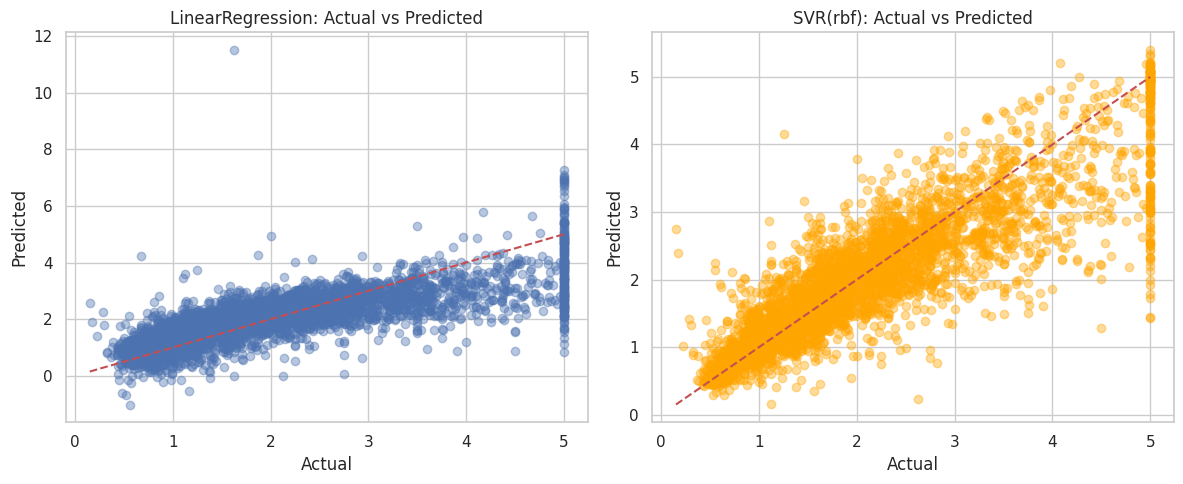

In [7]:
# 문제 3: 산점도 확인
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test_reg, pred_lr, alpha=0.4)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
axes[0].set_title('LinearRegression: Actual vs Predicted')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

axes[1].scatter(y_test_reg, pred_svr, alpha=0.4, color='orange')
axes[1].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
axes[1].set_title('SVR(rbf): Actual vs Predicted')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()


### 문제 3 해석 작성
- (작성) 선형 모델의 한계가 드러난 패턴
- (작성) SVR 성능 개선 이유(비선형 함수 언급)

**답안:**

선형 회귀 모델의 경우 실제값이 증가함에 따라 예측값도 증가하는 경향은 보이지만, 일부 구간에서는 오차가 크게 발생하는 패턴이 나타난다. 특히 실제값이 크거나 작은 구간에서 예측값이 직선 형태로 제한되어 비선형적인 패턴을 충분히 반영하지 못하는 한계를 보인다.

반면 SVR 모델은 RBF 커널을 사용하여 비선형적인 관계를 학습할 수 있으므로, 실제값과 예측값이 대각선에 더 가깝게 분포하며 전반적으로 예측 정확도가 향상된 모습을 보인다. 비선형 커널을 통해 복잡한 데이터 패턴을 효과적으로 반영할 수 있기 때문에 선형 회귀보다 더 우수한 성능을 나타낸다.



### 문제 4
SVR의 `C`, `epsilon`을 바꿔 성능 변화를 관찰하고, 과적합 방지 전략을 설명하세요.


In [9]:
# 문제 4: 하이퍼파라미터 실험
C_list = [1, 10, 50]
eps_list = [0.01, 0.1, 0.3]

rows = []
for c in C_list:
    for eps in eps_list:
        # TODO 11) 루프 변수 c, eps를 SVR에 적용
        model = SVR(kernel='rbf', C=c, epsilon=eps)
        model.fit(X_train_reg_scaled, y_train_reg)
        pred = model.predict(X_test_reg_scaled)
        rows.append({
            'C': c,
            'epsilon': eps,
            'MSE': mean_squared_error(y_test_reg, pred),
            'R2': r2_score(y_test_reg, pred)
        })

# TODO 12) R2 기준 내림차순
svr_grid_result = pd.DataFrame(rows).sort_values('R2', ascending=False).reset_index(drop=True)
svr_grid_result


,C,epsilon,MSE,R2
0,50,0.30,0.309483,0.763827
1,50,0.10,0.316295,0.758629
2,50,0.01,0.318321,0.757083
3,10,0.30,0.319304,0.756333
4,10,0.10,0.323697,0.752980
5,10,0.01,0.324228,0.752575
6,1,0.30,0.352804,0.730768
7,1,0.10,0.357004,0.727563
8,1,0.01,0.357802,0.726954


### 문제 4 해석 작성
- (작성) `C` 증가/감소가 편향 및 분산에 미치는 영향
- (작성) `epsilon` 변화가 예측 민감도에 미치는 영향
- (작성) 결론 작성(과적합 방지 전략)

**답안:**

C 값이 증가할수록 R2값이 증가하고 MSE는 감소하는 경향을 보인다. 이는 C가 커질수록 오차에 대한 패널티가 커져 모델이 학습 데이터에 더 잘 맞도록 학습되기 때문이다. 그러나 C 값이 지나치게 커질 경우 학습 데이터에 과도하게 맞추어 과적합이 발생할 가능성이 있다. 반대로 C 값이 작은 경우에는 모델이 단순해져 편향이 증가하고 예측 성능이 저하되는 경향을 보인다.

epsilon이 커질수록 작은 오차에 대해 민감하지 않게 되어 모델이 부드럽게 예측을 수행할 수 있게 된다. 해당 문제에서는 epsilon이 0.3일 때 상대적으로 높은 R2값을 보여, 적절한 epsilon은 성능 향상에 기여함을 확인할 수 있다.

해당 문제에서는 C=50, epsilon=0.3에서 가장 높은 성능을 보였으며, 과적합을 방지하기 위해서는 적절한 C와 epsilon 값을 선택하고, 교차 검증 등을 활용하여 최적의 하이퍼파라미터를 탐색하는 것이 중요하다.


## [Section 3] Decision Tree & Ensemble

### 문제 5
`DecisionTreeRegressor` vs `RandomForestRegressor` 성능 비교


In [10]:
# 문제 5: Bagging 비교
dt = DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE)
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)

# TODO 13) DecisionTree 학습 메서드
dt.fit(X_train_reg, y_train_reg)
# TODO 14) RandomForest 학습 메서드
rf.fit(X_train_reg, y_train_reg)
pred_dt = dt.predict(X_test_reg)
pred_rf = rf.predict(X_test_reg)

result_q5 = pd.DataFrame({
    'Model': ['DecisionTreeRegressor', 'RandomForestRegressor'],
    'MSE': [mean_squared_error(y_test_reg, pred_dt), mean_squared_error(y_test_reg, pred_rf)],
    'R2': [r2_score(y_test_reg, pred_dt), r2_score(y_test_reg, pred_rf)]
})
result_q5


,Model,MSE,R2
0,DecisionTreeRegressor,0.422045,0.677928
1,RandomForestRegressor,0.272759,0.791852


### 문제 5 해석 작성
- (작성) 왜 Random Forest가 단일 트리보다 Variance를 줄이는가?
- (작성) Diversity Theorem 관점에서 샘플 및 특성 랜덤성의 역할

**답안:**

RandomForestRegressor는 DecisionTreeRegressor보다 낮은 MSE와 높은 R2값을 보여 더 우수한 성능을 나타냈다. 단일 결정트리는 학습 데이터에 민감하여 Variance가 크고 과적합이 발생하기 쉬운 반면, 앙상블 기법인 Random Forest는 여러 트리의 예측값을 평균내어 분산을 감소시킨다.

또한 Diversity Theorem 관점에서 볼 때, Random Forest는 각 트리가 서로 다른 데이터와 특성을 사용하도록 하여 다양한 모델을 만든다. 이로 인해 트리들이 서로 다른 실수를 하게 되고, 이를 평균내어 예측하면 전체 오차가 줄어든다. 이러한 샘플 및 특성의 랜덤성은 각 모델의 오차 패턴을 서로 다르게 만들어, 앙상블 평균 과정에서 오차가 상쇄되도록 한다. 따라서 전체 모델의 일반화 성능이 향상되고 과적합이 완화된다.

### 문제 6
Boosting 성능 비교 및 Residual 학습 원리


In [11]:
# 문제 6: Boosting
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=200, learning_rate=0.05, max_depth=3)

# TODO 15) GradientBoosting 학습 메서드
gbr.fit(X_train_reg, y_train_reg)
# TODO 16) GradientBoosting 예측 메서드
pred_gbr = gbr.predict(X_test_reg)

result_q6 = pd.DataFrame({
    'Model': ['LinearRegression', 'SVR(rbf)', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'MSE': [
        mean_squared_error(y_test_reg, pred_lr),
        mean_squared_error(y_test_reg, pred_svr),
        mean_squared_error(y_test_reg, pred_dt),
        mean_squared_error(y_test_reg, pred_rf),
        mean_squared_error(y_test_reg, pred_gbr)
    ],
    'R2': [
        r2_score(y_test_reg, pred_lr),
        r2_score(y_test_reg, pred_svr),
        r2_score(y_test_reg, pred_dt),
        r2_score(y_test_reg, pred_rf),
        r2_score(y_test_reg, pred_gbr)
    ]
}).sort_values('R2', ascending=False).reset_index(drop=True)
result_q6


,Model,MSE,R2
0,RandomForestRegressor,0.272759,0.791852
1,GradientBoostingRegressor,0.291214,0.777768
2,SVR(rbf),0.323697,0.752980
3,DecisionTreeRegressor,0.422045,0.677928
4,LinearRegression,0.555892,0.575788


### 문제 6 해석 작성
- (작성) GBM이 이전 단계 잔차를 어떤 방식으로 학습하는지 단계별로 설명
- (작성) 위 실험에서의 GBM과 랜덤포레스트의 성능(R2) 차이를 Bias-Variance Trade-off로 해석

**답안:**

GBM은 먼저 초기 예측값을 설정한 뒤, 실제값과의 차이(잔차)를 계산한다. 이후 새로운 결정트리가 이 잔차를 예측하도록 학습되고, 기존 예측값에 learning rate를 곱한 값을 더해 점차 성능을 개선한다. 이 과정을 반복하면서 모델은 이전 단계의 오류를 보완하는 방향으로 점차 정교해진다.

이 실험에서는 Random Forest가 R2 = 0.7918로 가장 높은 성능을 보였고, GBM은 R2 = 0.7778로 성능을 나타냈다. Bias-Variance Trade-off 관점에서 보면, Random Forest는 여러 트리를 평균하여 분산을 줄이는 데 강점이 있다. 반면 GBM은 순차적으로 모델을 개선하며 편향을 줄이는 데 효과적이다.


## [Section 4] 결론 및 분석

### 문제 7
분류 문제에서 Accuracy가 아닌 F1-score가 중요한 상황을 확인하세요.


In [12]:
# 문제 7: 분류
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE,
    # TODO 17) 클래스 비율 유지를 위한 설정
    stratify=y_clf
)

scaler_clf = StandardScaler()
# TODO 18) 분류 데이터 학습 스케일링 메서드
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

from sklearn.ensemble import RandomForestClassifier
clf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=300)
clf_model.fit(X_train_clf, y_train_clf)
pred_clf = clf_model.predict(X_test_clf)

print('Accuracy:', accuracy_score(y_test_clf, pred_clf))
print('F1-macro:', f1_score(y_test_clf, pred_clf, average='macro'))
print('F1-weighted:', f1_score(y_test_clf, pred_clf, average='weighted'))
print('\nClassification Report\n', classification_report(y_test_clf, pred_clf))


Accuracy: 1.0
F1-macro: 1.0
F1-weighted: 1.0

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



### 문제 7 해석 작성
- (작성) Accuracy가 왜 클래스 불균형 데이터에서 왜곡될 수 있는지
- (작성) F1-score를 Accuracy보다 우선 확인해야 하는 상황 예시 (앞 문항과 연결하여 작성)

**답안:**

Accuracy는 전체 데이터 중에서 맞게 예측한 비율을 의미하므로, 클래스 불균형 데이터에서는 성능을 정확하게 반영하지 못할 수 있다. 예를 들어 금융 거래 데이터에서는 정상 거래가 대부분이고, 사기 거래는 매우 적은 비율을 차지하는 경우가 많다. 이때 모든 거래를 정상 거래로 예측하더라도 Accuracy는 매우 높게 나타날 수 있다. 그러나 실제로는 사기 거래를 전혀 탐지하지 못하므로 의미 있는 모델이라고 보기 어렵다.

금융 사기 탐지와 같이 소수 클래스의 정확한 탐지가 중요한 문제에서는 Accuracy보다 F1-score를 우선적으로 확인해야 한다. F1-score를 통해 모델의 실제 성능을 보다 정확하게 평가할 수 있다.



### 문제 8
최종 선택 모델의 Feature Importance를 출력하고 도메인 관점으로 왜 이러한 결과가 나왔는지 생각해보세요 ^ㅡ^


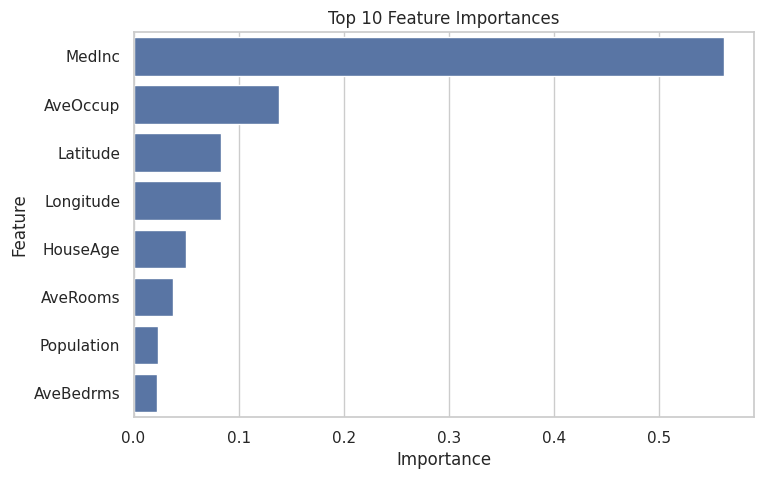

,0
MedInc,0.561583
AveOccup,0.138812
Latitude,0.083399
Longitude,0.083280
HouseAge,0.050154
AveRooms,0.037396
Population,0.022901
AveBedrms,0.022474


In [13]:
# 문제 8: 특성 중요도 시각화
final_model = rf
importance = pd.Series(final_model.feature_importances_, index=X_train_reg.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importance.values[:10], y=importance.index[:10], orient='h')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

importance.head(10)


## 제출 전 체크리스트
- [ O ] Section 1~4 모든 코드 작성 및 실행
- [ O ] 서술형 문항 답안 작성


긴 과제 진행하시느라 정말 고생 많으셨습니다.

코드작성과 해석을 스스로 정리해보신 만큼, 지도학습 핵심 개념을 탄탄하게 가져가는 기회가 되셨으면 합니다.
감사합니다.
